In [1]:
import os
import time
import traceback
import numpy as np
import pandas as pd
from dataloader import TrimodalLoader
from model import TrimodalModel
import torch


## Process
1. Load all data
2. Sub or oversample so that all dataset samples align
3. Form inputs of shape [mod1_x, mod2_x, mod3_x], [y]
4. Train embracenet

In [2]:
def load_iris():
    """Loads iris features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../iris/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"iris_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels
        

In [3]:
def load_fingerprint():
    """Loads fingerprint features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../fingerprint/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"fp_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [4]:
def load_face():
    """Loads face features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../face/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"face_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [5]:
if len(os.listdir("feats")) == 0:
    emb_iris, lab_iris = load_iris()
    emb_fp, lab_fp = load_fingerprint()
    emb_face, lab_face = load_face()
else:
    emb_iris = pd.read_csv("feats/iris.csv")
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

In [6]:
if len(os.listdir("feats")) == 0:

    print(len(lab_iris), len(lab_fp), len(lab_face))
    emb_iris["label"] = lab_iris
    emb_fp["label"] = lab_fp
    emb_face["label"] = lab_face

    emb_iris.to_csv("feats/iris.csv", index=False)
    emb_fp.to_csv("feats/fingerprint.csv", index=False)
    emb_face.to_csv("feats/face.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris.csv")    
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

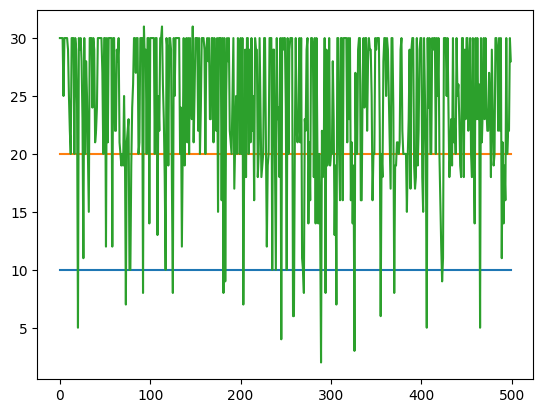

In [7]:
import matplotlib.pyplot as plt
plt.plot(emb_iris["label"].value_counts().sort_index())
plt.plot(emb_fp["label"].value_counts().sort_index())
plt.plot(emb_face["label"].value_counts().sort_index()) 

In [8]:
def get_fusion(df1, df2, df3):
    """
    Concatenates three dataframes into a single dataframe with pairs of embeddings and labels.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames containing embeddings and labels.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame with balanced pairs of embeddings and labels.
    """
    final_df1 = pd.DataFrame()
    final_df2 = pd.DataFrame()
    final_df3 = pd.DataFrame()
    
    
    # Iterate over unique labels
    for label in df1['label'].unique():
        # Filter each DataFrame for the current label
        sub_df1 = df1[df1['label'] == label]
        sub_df2 = df2[df2['label'] == label]
        sub_df3 = df3[df3['label'] == label]
        
        # Determine the maximum number of samples across the three DataFrames
        num_samples = max(len(sub_df1), len(sub_df2), len(sub_df3))
        
        # Oversample each subset to match the maximum sample size
        sub_df1 = sub_df1.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df2 = sub_df2.sample(num_samples, replace=True).reset_index(drop=True)
        sub_df3 = sub_df3.sample(num_samples, replace=True).reset_index(drop=True)
        
        final_df1 = pd.concat([final_df1, sub_df1], axis=0)
        final_df2 = pd.concat([final_df2, sub_df2], axis=0)
        final_df3 = pd.concat([final_df3, sub_df3], axis=0)
        
    
    return final_df1, final_df2, final_df3


In [9]:
def remap_labels(emb_iris, emb_face, emb_fp):
    mapping = {val: idx for idx, val in enumerate(emb_iris["label"].unique())}
    
    emb_iris["label"] = emb_iris["label"].map(mapping)
    emb_face["label"] = emb_face["label"].map(mapping)
    emb_fp["label"] = emb_fp["label"].map(mapping)
    
    return emb_iris, emb_face, emb_fp

In [10]:
if "iris_sampled.csv" not in os.listdir("feats"):
    emb_iris, emb_face, emb_fp = get_fusion(emb_iris, emb_face, emb_fp)
    
    emb_iris, emb_face, emb_fp = remap_labels(emb_iris, emb_face, emb_fp)
    
    emb_iris.to_csv("feats/iris_sampled.csv", index=False)
    emb_fp.to_csv("feats/fingerprint_sampled.csv", index=False)
    emb_face.to_csv("feats/face_sampled.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris_sampled.csv")
    emb_fp = pd.read_csv("feats/fingerprint_sampled.csv")
    emb_face = pd.read_csv("feats/face_sampled.csv")

In [11]:
len(emb_iris), len(emb_face), len(emb_fp)

(12603, 12603, 12603)

In [12]:
# Prepare dataloader
train_subjects_uniq = len(emb_iris["label"].unique()) // 5
train_subjects = emb_iris["label"].unique()[:train_subjects_uniq]
test_subjects = emb_iris["label"].unique()[train_subjects_uniq:]

iris_train = emb_iris[emb_iris["label"].isin(train_subjects)]
fp_train = emb_fp[emb_fp["label"].isin(train_subjects)]
face_train = emb_face[emb_face["label"].isin(train_subjects)]


iris_test = emb_iris[emb_iris["label"].isin(test_subjects)]
fp_test = emb_fp[emb_fp["label"].isin(test_subjects)]
face_test = emb_face[emb_face["label"].isin(test_subjects)]


iris_train_x, iris_train_y = iris_train.drop("label", axis=1), iris_train["label"]
fp_train_x, fp_train_y = fp_train.drop("label", axis=1), fp_train["label"]
face_train_x, face_train_y = face_train.drop("label", axis=1), face_train["label"]


iris_test_x, iris_test_y = iris_test.drop("label", axis=1), iris_test["label"]
fp_test_x, fp_test_y = fp_test.drop("label", axis=1), fp_test["label"]
face_test_x, face_test_y = face_test.drop("label", axis=1), face_test["label"]

In [13]:
iris_train = iris_train.drop(columns="label")

In [14]:
list(iris_train_y)[:10], list(fp_train_y)[:10], list(face_train_y)[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
len(iris_train_y), len(fp_train_y), len(face_train_y)

(2638, 2638, 2638)

In [16]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

True

In [17]:
list(iris_test_y) == list(fp_test_y) == list(face_test_y)

True

In [18]:
# We only need one set of labels
y = iris_train_y

In [19]:
dataloader = TrimodalLoader(
    torch.tensor(iris_train_x.values, dtype=torch.float32), 
    torch.tensor(fp_train_x.values, dtype=torch.float32), 
    torch.tensor(face_train_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

test_loader = TrimodalLoader(
    torch.tensor(iris_test_x.values, dtype=torch.float32), 
    torch.tensor(fp_test_x.values, dtype=torch.float32), 
    torch.tensor(face_test_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

In [20]:
iris_train_y

0        0
1        0
2        0
3        0
4        0
        ..
2633    99
2634    99
2635    99
2636    99
2637    99
Name: label, Length: 2638, dtype: int64

In [21]:
iris_train.iloc[0].shape

(1408,)

In [22]:
# initialize
batch_size = 32
device = "cpu"
train_path = "tmp/train/"
max_steps = 1000
log_freq = 2
summary_freq = 5
save_freq = 5
sleep_ratio = 0
restore_path = None
global_step = 0
os.environ["CUDA_VISIBLE_DEVICES"] = device
os.makedirs(train_path, exist_ok=True)

In [23]:
# Prepare model
model = TrimodalModel()
input_size_list = [iris_train.iloc[0].shape[0], fp_train_x.iloc[0].shape[0], face_train_x.iloc[0].shape[0]]
print(input_size_list)

print(input_size_list)
n_classes = iris_train_y.nunique()
print("N classes: ", n_classes)
model.prepare(is_training=True, input_size_list=input_size_list, global_step=global_step, n_classes=n_classes)

[1408, 1408, 512]
[1408, 1408, 512]
N classes:  100
Created docking_0 with input size 1408 and output size 256
Parameter containing:
tensor([[ 0.0258, -0.0148, -0.0116,  ...,  0.0240, -0.0256,  0.0135],
        [ 0.0081, -0.0017, -0.0130,  ...,  0.0067,  0.0183, -0.0121],
        [-0.0204, -0.0208, -0.0153,  ...,  0.0188, -0.0103,  0.0143],
        ...,
        [-0.0192, -0.0245,  0.0206,  ..., -0.0182,  0.0244,  0.0168],
        [-0.0256, -0.0026, -0.0257,  ...,  0.0157, -0.0100, -0.0187],
        [ 0.0255,  0.0144,  0.0081,  ..., -0.0161, -0.0172,  0.0047]],
       requires_grad=True)
Created docking_1 with input size 1408 and output size 256
Parameter containing:
tensor([[-0.0119,  0.0089, -0.0094,  ..., -0.0226, -0.0049,  0.0135],
        [ 0.0077, -0.0100,  0.0265,  ...,  0.0162, -0.0052,  0.0016],
        [ 0.0021,  0.0034,  0.0031,  ...,  0.0095, -0.0160, -0.0084],
        ...,
        [ 0.0106,  0.0004, -0.0052,  ...,  0.0259, -0.0222, -0.0078],
        [ 0.0235, -0.0237, -0.00

In [24]:
# model > restore
if restore_path is not None:
    model.restore(ckpt_path=restore_path)
    print("restored the model")

# model > summary
summary_path = os.path.join(train_path, "summary")

In [25]:
iris_train.iloc[0].shape, fp_train_x.iloc[0].shape, face_train_x.iloc[0].shape

((1408,), (1408,), (512,))

In [26]:
print("begin training")
local_train_step = 0
losses = []
# model.load_weights()

while model.global_step < max_steps:
    global_train_step = model.global_step + 1
    local_train_step += 1

    start_time = time.time()


    input_list, truth_list = dataloader.get_batch(
        batch_size=batch_size
    )  # [mod1, mod2, ...], label
    truth_list = torch.as_tensor(
        [int(label) for label in truth_list],  # Convert NumPy scalar arrays to Python integers
        dtype=torch.long,
        device=device)
    
    print(truth_list)
    loss = model.train_step(
        input_list=input_list, truth_list=truth_list
    )
    losses.append(loss)
    print(loss)
    duration = time.time() - start_time

    if local_train_step % log_freq == 0:
        print(
            "step %d, loss %.6f (%.3f sec/batch)"
            % (global_train_step, loss, duration)
        )

    if local_train_step % save_freq == 0:
        model.save(base_path=train_path)
        print("saved a model checkpoint at step %d" % (global_train_step))

# except KeyboardInterrupt:
#     print("interrupted (KeyboardInterrupt)")
# except Exception as e:
#     print(traceback.format_exc())

# finalize
print("finished")


begin training
tensor([89, 44, 12, 26, 80,  1, 86, 88, 72, 15,  1, 33, 64, 98, 44, 55, 42,  4,
        58, 56, 96, 16, 12, 76,  6, 95, 82, 41, 31, 99, 15, 66])
Selection probabilities:  tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
Modality indices (r_i):  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1

TODO: Save embracenet weights and get output. 

In [27]:
# model.save_weights()

In [28]:
truths = []
preds = []
model.load_weights()


c:\Users\sebas\Desktop\repos\multimodal_person_recognition\src\embracenet\model.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.embracenet.load_state_dict(to

In [29]:
len(face_test_x) // batch_size

311

In [30]:
train_embs, train_truths = [], []
for i in range(len(face_train_x) // batch_size):
    input_list, truth_list = test_loader.get_batch(batch_size=batch_size)
    output, truth = model.test_step(input_list, truth_list)
    train_truths.extend(np.array(truth_list))
    train_embs.extend(output.detach().numpy())

[array(7, dtype=int64), array(24, dtype=int64), array(65, dtype=int64), array(91, dtype=int64), array(38, dtype=int64), array(94, dtype=int64), array(70, dtype=int64), array(18, dtype=int64), array(95, dtype=int64), array(3, dtype=int64), array(48, dtype=int64), array(10, dtype=int64), array(96, dtype=int64), array(67, dtype=int64), array(84, dtype=int64), array(19, dtype=int64), array(4, dtype=int64), array(66, dtype=int64), array(72, dtype=int64), array(29, dtype=int64), array(16, dtype=int64), array(27, dtype=int64), array(76, dtype=int64), array(76, dtype=int64), array(93, dtype=int64), array(90, dtype=int64), array(17, dtype=int64), array(51, dtype=int64), array(81, dtype=int64), array(76, dtype=int64), array(40, dtype=int64), array(37, dtype=int64)]
Selection probabilities:  tensor([[0.2570, 0.2081, 0.5349],
        [0.2521, 0.3716, 0.3762],
        [0.0440, 0.3691, 0.5869],
        [0.2197, 0.4019, 0.3783],
        [0.4760, 0.2477, 0.2763],
        [0.5162, 0.0705, 0.4133],
    

In [31]:
embeddings, truths = [], []

for i in range(len(face_test_x) // batch_size):
    input_list, truth_list = test_loader.get_batch(batch_size=batch_size)
    output, truth = model.test_step(input_list, truth_list)
    truths.extend(np.array(truth_list))
    embeddings.extend(output.detach().numpy())



[array(56, dtype=int64), array(73, dtype=int64), array(39, dtype=int64), array(88, dtype=int64), array(17, dtype=int64), array(32, dtype=int64), array(30, dtype=int64), array(64, dtype=int64), array(89, dtype=int64), array(33, dtype=int64), array(67, dtype=int64), array(12, dtype=int64), array(11, dtype=int64), array(22, dtype=int64), array(75, dtype=int64), array(89, dtype=int64), array(55, dtype=int64), array(7, dtype=int64), array(24, dtype=int64), array(58, dtype=int64), array(14, dtype=int64), array(13, dtype=int64), array(71, dtype=int64), array(75, dtype=int64), array(41, dtype=int64), array(94, dtype=int64), array(18, dtype=int64), array(50, dtype=int64), array(51, dtype=int64), array(19, dtype=int64), array(90, dtype=int64), array(20, dtype=int64)]
Selection probabilities:  tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        

In [32]:
y

0        0
1        0
2        0
3        0
4        0
        ..
2633    99
2634    99
2635    99
2636    99
2637    99
Name: label, Length: 2638, dtype: int64

In [33]:
len(truths)

9952

In [34]:
preds

[]

In [35]:
import numpy as np

def find_closest_embeddings_numpy(embeddings):
    """
    Finds the closest embedding (by cosine similarity) for each embedding in the input.

    Args:
        embeddings (np.ndarray): A 2D array of shape (N, D), where N is the number
                                  of embeddings and D is the embedding dimension.

    Returns:
        closest_indices (np.ndarray): A 1D array of shape (N,) containing the index
                                      of the closest embedding for each embedding.
        distance_matrix (np.ndarray): A 2D array of shape (N, N) containing cosine
                                       distances between embeddings.
    """
    # Normalize embeddings to compute cosine similarity
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms

    # Compute cosine similarity matrix
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

    # Convert similarity to cosine distance (1 - cosine similarity)
    distance_matrix = 1 - similarity_matrix

    # Fill diagonal with a large value to ignore self-similarity
    np.fill_diagonal(distance_matrix, np.inf)

    # Find the index of the minimum distance for each row
    closest_indices = np.argmin(distance_matrix, axis=1)

    return closest_indices, distance_matrix


In [36]:
closes_indices, distance_mtx = find_closest_embeddings_numpy(embeddings)

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_embs, train_truths)

preds = clf.predict(embeddings)
accuracy_score(truths, preds)

0.37359324758842444

In [38]:
len(y)

2638

In [39]:
preds = [truths[i] for i in closes_indices]
n_correct = 0
for a, b in zip(truths, preds):
    n_correct += a == b

acc = n_correct / len(truths)
print(acc)

0.4989951768488746


In [40]:
closes_indices

array([8214, 3131, 3567, ..., 2974, 1553, 5754], dtype=int64)

In [41]:
print(torch.argmax(output[0]))

tensor(42)


In [42]:
45056 / 256

176.0

In [43]:
torch.cuda.is_available()

False

In [44]:
input_size_list

[1408, 1408, 512]

In [45]:
512 * 32

16384

Text(0.5, 1.0, 'EmbraceNet Loss')

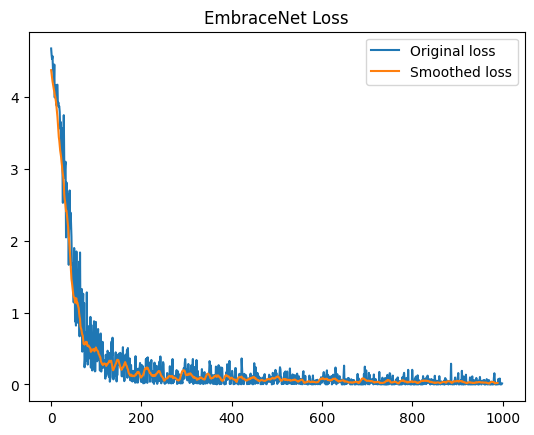

In [46]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

sigma = 5
kernel_size = 11  # Choose an odd number
kernel = gaussian_kernel(kernel_size, sigma)
smoothed_vector = np.convolve(losses, kernel, mode='same')

plt.plot(losses, label="Original loss")
plt.plot(smoothed_vector[5:-5], label="Smoothed loss")
plt.legend()
plt.title("EmbraceNet Loss")
